In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Pastikan ini diimpor
from IPython.display import display  # Jika Anda menggunakannya


In [2]:
# Tetapkan seed untuk reproduksi
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# Unduh stopwords untuk Bahasa Indonesia
nltk.download('stopwords')
stopwords_indonesia = stopwords.words('indonesian')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ical_lucifer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Fungsi preprocessing
def preprocess_text(text):
    # Menghapus karakter yang tidak relevan dan menurunkan semua huruf menjadi kecil
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Menghapus stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords_indonesia])
    return text


In [5]:
# Memuat data
data = pd.read_csv('../../models/ANN/data_set.csv')

# Membuat kolom 'Label' sebagai kombinasi dari 'Tipe_Emosi' dan 'Sumber_Emosi'
data['Label'] = data['Tipe_Emosi'] + "_" + data['Sumber_Emosi']

# Preprocessing teks
data['Input_Text'] = data['Level_Emosi'] + " " + data['Tipe_Emosi'] + " " + data['Sumber_Emosi']
data['Input_Text'] = data['Input_Text'].apply(preprocess_text)

# Membuat mapping label ke pertanyaan
label_to_questions = {}

for idx, row in data.iterrows():
    label = row['Label']
    questions = [q.strip() for q in row['Pertanyaan_Analisis'].split('|')]
    if label not in label_to_questions:
        label_to_questions[label] = questions
    else:
        # Menambahkan pertanyaan unik hingga maksimal 5 pertanyaan
        existing_questions = set(label_to_questions[label])
        for q in questions:
            if q not in existing_questions and len(label_to_questions[label]) < 5:
                label_to_questions[label].append(q)
                existing_questions.add(q)

# Memastikan setiap label memiliki 5 pertanyaan unik
for label, questions in label_to_questions.items():
    label_to_questions[label] = list(dict.fromkeys(questions))[:5]


In [6]:
# Update TfidfVectorizer dan LabelEncoder
vectorizer = TfidfVectorizer(
    max_features=2000, 
    ngram_range=(1, 2), 
    stop_words=stopwords_indonesia,
    min_df=2  # Mengabaikan kata yang muncul kurang dari 2 kali
)
X = vectorizer.fit_transform(data['Input_Text']).toarray()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Label'])


/Users/ical_lucifer/Documents/Project/SoulBabble/Phase 2/Machine Learning/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [7]:
# Periksa jumlah kelas dan total data
print(f"Jumlah total data: {len(data)}")
print(f"Jumlah kelas unik: {len(set(y))}")


Jumlah total data: 10080
Jumlah kelas unik: 2016


In [8]:
# Pastikan test_size cukup untuk jumlah kelas
test_size = max(0.2, len(set(y)) / len(y))
print(f"Adjusted test size: {test_size}")


Adjusted test size: 0.2


In [9]:
# Lakukan train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)


In [10]:
# Periksa distribusi kelas pada train dan test set
print("Distribusi kelas pada train set:")
print(pd.Series(y_train).value_counts())

print("\nDistribusi kelas pada test set:")
print(pd.Series(y_test).value_counts())


Distribusi kelas pada train set:
898     4
1937    4
1564    4
1827    4
990     4
       ..
1646    4
603     4
1051    4
1186    4
845     4
Name: count, Length: 2016, dtype: int64

Distribusi kelas pada test set:
573     1
190     1
626     1
1761    1
7       1
       ..
172     1
1519    1
1965    1
1637    1
293     1
Name: count, Length: 2016, dtype: int64


In [11]:
# Tabel distribusi kelas
train_class_distribution = pd.Series(y_train).value_counts().sort_index()
test_class_distribution = pd.Series(y_test).value_counts().sort_index()

class_labels = label_encoder.inverse_transform(range(len(train_class_distribution)))

distribution_df = pd.DataFrame({
    'Kelas': class_labels,
    'Train': train_class_distribution.values,
    'Test': test_class_distribution.values
})

display(distribution_df)


,Kelas,Train,Test
0,Aneh_Apotek,4,1
1,Aneh_Arena Konser,4,1
2,Aneh_Arena Skate,4,1
3,Aneh_Balai Kota,4,1
4,Aneh_Bandara,4,1
...,...,...,...
2011,Tertarik_Tempat Parkir,4,1
2012,Tertarik_Terminal Bus,4,1
2013,Tertarik_Transportasi Umum,4,1
2014,Tertarik_Warung,4,1


In [12]:
# Membuat model ANN yang disederhanakan
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model


In [13]:
# Callbacks untuk Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Ubah ekstensi file menjadi .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [14]:
# Membuat model
model = build_model(X_train.shape[1], len(set(y)))


In [15]:
# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/50
496/504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0053 - loss: 7.6001
Epoch 1: val_loss improved from inf to 6.57048, saving model to best_model.keras
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0053 - loss: 7.5989 - val_accuracy: 0.1716 - val_loss: 6.5705
Epoch 2/50
498/504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1329 - loss: 5.2609
Epoch 2: val_loss improved from 6.57048 to 1.86833, saving model to best_model.keras
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1336 - loss: 5.2516 - val_accuracy: 0.8894 - val_loss: 1.8683
Epoch 3/50
479/504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5618 - loss: 2.1248
Epoch 3: val_loss improved from 1.86833 to 0.41548, saving model to best_model.keras
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5627 - loss: 2.1171 - val_accuracy: 0.9906 - val_loss: 0.4155
Epoch 4/50
478/504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 1.0745
Epoch 4: val_loss improved from 0.41548 to 0.13422, sa

In [16]:
# Evaluasi model
train_score = model.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {train_score[1]*100:.2f}%")

test_score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


Train Accuracy: 100.00%
Test Accuracy: 100.00%


In [17]:
# Prediksi
y_pred = model.predict(X_test).argmax(axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


In [18]:
# Pastikan target_names sesuai dengan kelas yang ada di y_test
unique_classes = sorted(set(y_test))  # Ambil kelas unik dari y_test
target_names = label_encoder.inverse_transform(unique_classes)  # Ambil nama kelas sesuai


In [19]:
# Laporan klasifikasi dengan labels yang sesuai
print(classification_report(
    y_test, 
    y_pred, 
    target_names=target_names,
    labels=unique_classes
))


                                  precision    recall  f1-score   support

                     Aneh_Apotek       1.00      1.00      1.00         1
               Aneh_Arena Konser       1.00      1.00      1.00         1
                Aneh_Arena Skate       1.00      1.00      1.00         1
                 Aneh_Balai Kota       1.00      1.00      1.00         1
                    Aneh_Bandara       1.00      1.00      1.00         1
                    Aneh_Bioskop       1.00      1.00      1.00         1
                      Aneh_Bukit       1.00      1.00      1.00         1
                      Aneh_Danau       1.00      1.00      1.00         1
                       Aneh_Desa       1.00      1.00      1.00         1
                      Aneh_Event       1.00      1.00      1.00         1
                Aneh_Galeri Seni       1.00      1.00      1.00         1
         Aneh_Gedung Pertunjukan       1.00      1.00      1.00         1
           Aneh_Gedung Serbaguna     

In [20]:
# Tabel Laporan Klasifikasi
report = classification_report(
    y_test, 
    y_pred, 
    target_names=target_names,
    labels=unique_classes,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
display(report_df)


,precision,recall,f1-score,support
Aneh_Apotek,1.0,1.0,1.0,1.0
Aneh_Arena Konser,1.0,1.0,1.0,1.0
Aneh_Arena Skate,1.0,1.0,1.0,1.0
Aneh_Balai Kota,1.0,1.0,1.0,1.0
Aneh_Bandara,1.0,1.0,1.0,1.0
...,...,...,...,...
Tertarik_Warung,1.0,1.0,1.0,1.0
Tertarik_Zona Industri,1.0,1.0,1.0,1.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,2016.0


In [21]:
# Confusion Matrix
# cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
# cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

# plt.figure(figsize=(12, 10))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()


In [22]:
# Fungsi untuk memprediksi dan menampilkan pertanyaan
def predict_and_display_questions(level_emosi, tipe_emosi, sumber_emosi):
    # Membuat label dari input triplet
    label = f"{tipe_emosi}_{sumber_emosi}"
    
    # Cek apakah label ada dalam mapping
    if label not in label_to_questions:
        print(f"Tidak ada pertanyaan yang tersedia untuk kombinasi: ({level_emosi}, {tipe_emosi}, {sumber_emosi})")
        return
    
    # Membuat teks input untuk prediksi
    input_text = f"{level_emosi} {tipe_emosi} {sumber_emosi}"
    processed_text = preprocess_text(input_text)
    
    # Vektorisasi
    vector = vectorizer.transform([processed_text]).toarray()
    
    # Prediksi
    prediction = model.predict(vector).argmax(axis=1)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    
    # Verifikasi apakah prediksi sesuai dengan input label
    if predicted_label != label:
        print(f"Peringatan: Prediksi label ({predicted_label}) tidak sesuai dengan input label ({label}).")
    
    # Menampilkan pertanyaan yang relevan
    questions = label_to_questions.get(predicted_label, [])
    if questions:
        print(f"\nPertanyaan untuk ({level_emosi}, {tipe_emosi}, {sumber_emosi}):")
        for idx, question in enumerate(questions, 1):
            print(f"{idx}. {question}")
    else:
        print("Tidak ada pertanyaan yang tersedia untuk label ini.")


In [23]:
# Contoh penggunaan
print("\nContoh Prediksi dan Penampilan Pertanyaan:")
predict_and_display_questions("Sangat Buruk", "Kecewa", "Sekolah")
predict_and_display_questions("Sangat Baik", "Bersyukur", "Kegiatan Sosial")
predict_and_display_questions("Sangat Baik", "Penuh Harapan", "Danau") 



Contoh Prediksi dan Penampilan Pertanyaan:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Pertanyaan untuk (Sangat Buruk, Kecewa, Sekolah):
1. Apa yang membuat kamu merasa kecewa di Sekolah?
2. Apa yang bisa menyebabkan perasaan kecewa kamu di Sekolah?
3. Bagaimana situasi di Sekolah mempengaruhi perasaan kamu yang kecewa?
4. Bagaimana perasaan sangat buruk ini mempengaruhi keseharianmu di Sekolah?
5. Bagaimana kamu bisa mengatasi rasa kecewa setelah situasi yang tidak sesuai harapan di Sekolah?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Pertanyaan untuk (Sangat Baik, Bersyukur, Kegiatan Sosial):
1. Apa yang membuat kamu merasa bersyukur di Kegiatan Sosial?
2. Apa yang bisa menyebabkan perasaan bersyukur kamu di Kegiatan Sosial?
3. Bagaimana situasi di Kegiatan Sosial mempengaruhi perasaan kamu yang bersyukur?
4. Apa langkah yang dapat kamu ambil untuk memperbaiki perasaan sangat buruk di Kegiatan Sosial?
5. Apa yang membuat kamu merasa bersyukur di Kegiatan Sosial, dan bagaimana kamu bisa menunj

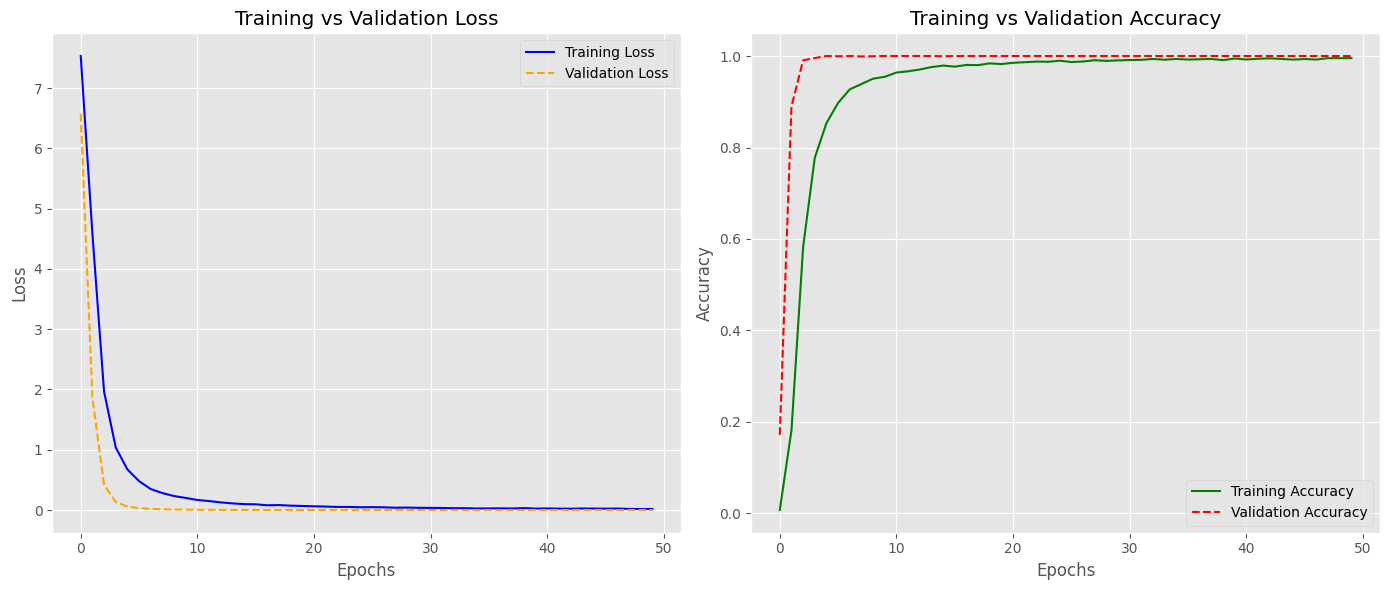

In [24]:
# Visualisasi Training dan Validation Loss dan Accuracy
plt.style.use('ggplot')  # Gaya plot yang lebih menarik

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# Menyimpan model dan preprocessing tools
model.save("../../app/models/emotion_tracking_model.keras")
joblib.dump(vectorizer, '../../app/models/vectorizer.pkl')  # Menyimpan TfidfVectorizer
joblib.dump(label_encoder, '../../app/models/label_encoder.pkl')  # Menyimpan LabelEncoder

print("Model, TfidfVectorizer, dan LabelEncoder berhasil disimpan!")


Model, TfidfVectorizer, dan LabelEncoder berhasil disimpan!


In [26]:
# Tabel Contoh Prediksi
def display_sample_predictions(X_sample, y_true, y_pred, num_samples=10):
    sample_indices = np.random.choice(range(len(X_sample)), size=num_samples, replace=False)
    samples = X_sample[sample_indices]
    true_labels = label_encoder.inverse_transform(y_true[sample_indices])
    pred_labels = label_encoder.inverse_transform(y_pred[sample_indices])
    
    # Jika Anda ingin menampilkan teks asli, pastikan untuk menyimpan atau mengaksesnya
    # Misalnya, jika Anda memiliki data asli dalam data_test, gunakan itu
    # Berikut adalah contoh jika Anda memiliki data_test asli
    # teks_sample = data_test['Input_Text'].iloc[sample_indices].values
    
    # Untuk ilustrasi, kita akan menggunakan teks asli dari data
    teks_sample = data['Input_Text'].iloc[sample_indices].values
    
    prediction_table = pd.DataFrame({
        'Input Text': teks_sample,
        'Label Sebenarnya': true_labels,
        'Prediksi Model': pred_labels
    })
    
    display(prediction_table)

# Misalkan Anda memiliki data input asli untuk X_test
# Jika tidak, Anda bisa mengabaikan kolom 'Input Text' atau mengisinya sesuai kebutuhan
# Berikut adalah contoh penggunaan dengan teks asli

print("\nTabel Contoh Prediksi:")
display_sample_predictions(X_test, y_test, y_pred, num_samples=10)



Tabel Contoh Prediksi:


,Input Text,Label Sebenarnya,Prediksi Model
0,buruk terinspirasi rumah,Euforis_Taman Nasional,Euforis_Taman Nasional
1,buruk tertarik pusat perbelanjaan,Bingung_Hutan,Bingung_Hutan
2,buruk kesal event,Cemas_Pusat Konferensi,Cemas_Pusat Konferensi
3,buruk takut stadion,Takut_Gedung Serbaguna,Takut_Gedung Serbaguna
4,buruk kesal arena skate,Takut_Apotek,Takut_Apotek
5,buruk tersenyum kegiatan sosial,Marah_Pertemuan,Marah_Pertemuan
6,buruk tertantang kegiatan sosial,Rindu_Lokasi Olahraga,Rindu_Lokasi Olahraga
7,buruk kesal laboratorium,Tertantang_Transportasi Umum,Tertantang_Transportasi Umum
8,buruk terkejut arena konser,Terinspirasi_Pusat Perbelanjaan,Terinspirasi_Pusat Perbelanjaan
9,buruk tertarik pelabuhan,Bahagia_Pusat Perbelanjaan,Bahagia_Pusat Perbelanjaan
